# Configuração do ambiente

In [4]:
!pip install datasets huggingface_hub torch matplotlib scikit-learn
!pip install transformers --upgrade
!pip install accelerate>0.21.0

import os

# Desativa o paralelismo para evitar deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

import datasets
from datasets import Dataset, DatasetDict, load_metric


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Objetivo

Desenvolver um modelo de machine learning para realizar análise de sentimentos em reviews de aplicativos e outros tipos de texto. O projeto utilizará técnicas de processamento de linguagem natural (NLP) para identificar e classificar as emoções expressas nos textos. O objetivo é criar uma ferramenta que melhore a compreensão do feedback dos usuários e outros conteúdos textuais, fornecendo insights valiosos de forma automatizada.

## Dataset

O dataset contém avaliações e notas dos 10 aplicativos mais populares na categoria de comida e bebidas, disponíveis na Google Play Store do Brasil. As notas variam de 1 a 5, e a ideia é fazer a seguinte classificação:

* 1 e 2: Avaliações Negativas
* 3: Avaliação Neutra
* 4 e 5: Avaliações Positivas

## Descrição das colunas:

* reviewId: ID da avaliação
* userName: Nome de usuário
* userImage: Avatar do usuário
* content: Texto da avaliação
* score: Nota atribuída na avaliação
* thumbsUpCount: Número de curtidas
* reviewCreatedVersion: Versão do aplicativo no momento da avaliação
* at: Data da avaliação
* replyContent: Texto da resposta à avaliação
* repliedAt: Data da resposta à avaliação
* appVersion: Versão do aplicativo
* sortOrder: Ordem de classificação
* appId: ID do aplicativo





In [6]:
# Informa a URL de importação do dataset
#url = "https://raw.githubusercontent.com/bpbastos/sentiment-analysis-ml-api/main/android_app_reviews.csv?token=GHSAT0AAAAAACSFFAPRMUHD2ZIBMDIWUJSWZWRHYEQ"
url = "../data/android_app_reviews.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',', encoding='utf-8')

#n_samples_per_class = min(dataset['score'].value_counts())

# Amostra a mesma quantidade de cada classe
#dataset = dataset.groupby('score').sample(n=n_samples_per_class, random_state=42)

#
dataset.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,9b2090fb-2acf-4ade-bff4-1bd65f714e89,Julia Lopes Ogleari,https://play-lh.googleusercontent.com/a-/ALV-U...,Só decepções. As últimas vezes que pedi com es...,1,49,10.32.0,2024-08-27 00:32:41,NaN,NaN,10.32.0,most_relevant,br.com.brainweb.ifood
1,fb9bccfd-573d-47cf-aafe-fbeafe53f55b,David Paul,https://play-lh.googleusercontent.com/a-/ALV-U...,Era muito bom quando a preocupação era atender...,1,5,10.27.0,2024-08-28 01:25:52,NaN,NaN,10.27.0,most_relevant,br.com.brainweb.ifood
2,a8da45e3-66c6-44b2-8ff3-905c9c266914,Larissa Keity,https://play-lh.googleusercontent.com/a-/ALV-U...,É frustrante vc fazer um pedido num restaurant...,1,8,10.32.0,2024-08-28 02:55:34,NaN,NaN,10.32.0,most_relevant,br.com.brainweb.ifood
3,edeb5bbd-7d01-4c02-88b2-c65c3b82373b,Lorenna Petri,https://play-lh.googleusercontent.com/a-/ALV-U...,O processo de cancelamento é dificultado para ...,1,201,10.28.0,2024-07-30 11:40:22,NaN,NaN,10.28.0,most_relevant,br.com.brainweb.ifood
4,1fa4b8eb-9423-4f8e-9ba7-3be0d5805f96,Jordana Araujo,https://play-lh.googleusercontent.com/a-/ALV-U...,Eu não consigo mais usar o app. Instalei ele d...,1,389,10.28.0,2024-08-03 16:26:19,NaN,NaN,10.28.0,most_relevant,br.com.brainweb.ifood


In [7]:
# Informações gerais sobre o dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12000 non-null  object
 1   userName              12000 non-null  object
 2   userImage             12000 non-null  object
 3   content               11999 non-null  object
 4   score                 12000 non-null  int64 
 5   thumbsUpCount         12000 non-null  int64 
 6   reviewCreatedVersion  10799 non-null  object
 7   at                    12000 non-null  object
 8   replyContent          5118 non-null   object
 9   repliedAt             5118 non-null   object
 10  appVersion            10799 non-null  object
 11  sortOrder             12000 non-null  object
 12  appId                 12000 non-null  object
dtypes: int64(2), object(11)
memory usage: 1.2+ MB


# Distribuição dos reviews por nota

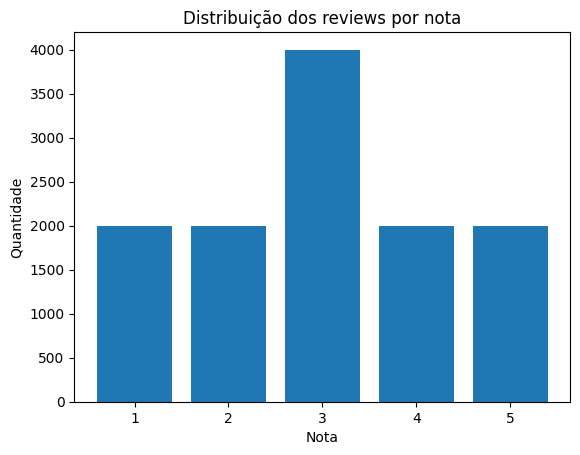

In [8]:
# Calcula a contagem de cada valor de 'score'
score_counts = dataset['score'].value_counts()

# Histograma do número de reviews de acordo com a nota:
plt.bar(score_counts.index, score_counts.values)
plt.xlabel('Nota')
plt.ylabel('Quantidade')
plt.title('Distribuição dos reviews por nota')
plt.show()

# Balanceamento do dataset

In [9]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

dataset['sentiment'] = dataset.score.apply(to_sentiment)

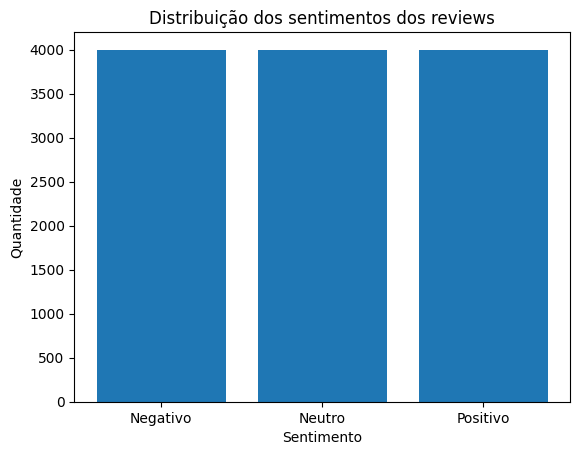

In [10]:
class_names = ['Negativo', 'Neutro', 'Positivo']
sentiment_counts = dataset['sentiment'].value_counts()
plt.bar(class_names, sentiment_counts.values)
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.title('Distribuição dos sentimentos dos reviews')
plt.show()


# Separação em conjunto de treino e conjunto de teste com holdout

In [11]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
# Separando os textos e as labels
X = dataset['content']  # Texto do Review
y = dataset['sentiment'] # Sentimento 0(negativo)/1(neutro)/2(negativo)

# Dividindo os dados em conjuntos de treinamento e teste
# Holdout
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Vetorização do texto usando CountVectorizer
vectorizer = CountVectorizer(analyzer = "word")

# Impute missing values in 'content' column with empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')

# Ajuste e transformação no conjunto de treino
X_train_vec = vectorizer.fit_transform(X_train)

# Transformação no conjunto de teste
X_test_vec = vectorizer.transform(X_test)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

# Modelagem
## Models e Ensembles - Sklearn

LR: 0.668437 (0.012492)
KNN: 0.531146 (0.010850)
CART: 0.637917 (0.014223)
NB-Multinomial: 0.630313 (0.010327)
SVM: 0.653229 (0.009597)
Bagging: 0.680937 (0.011572)
RF: 0.671771 (0.007547)
ET: 0.668958 (0.013240)
Ada: 0.568958 (0.013747)
GB: 0.583854 (0.011508)
Voting: 0.677813 (0.010856)


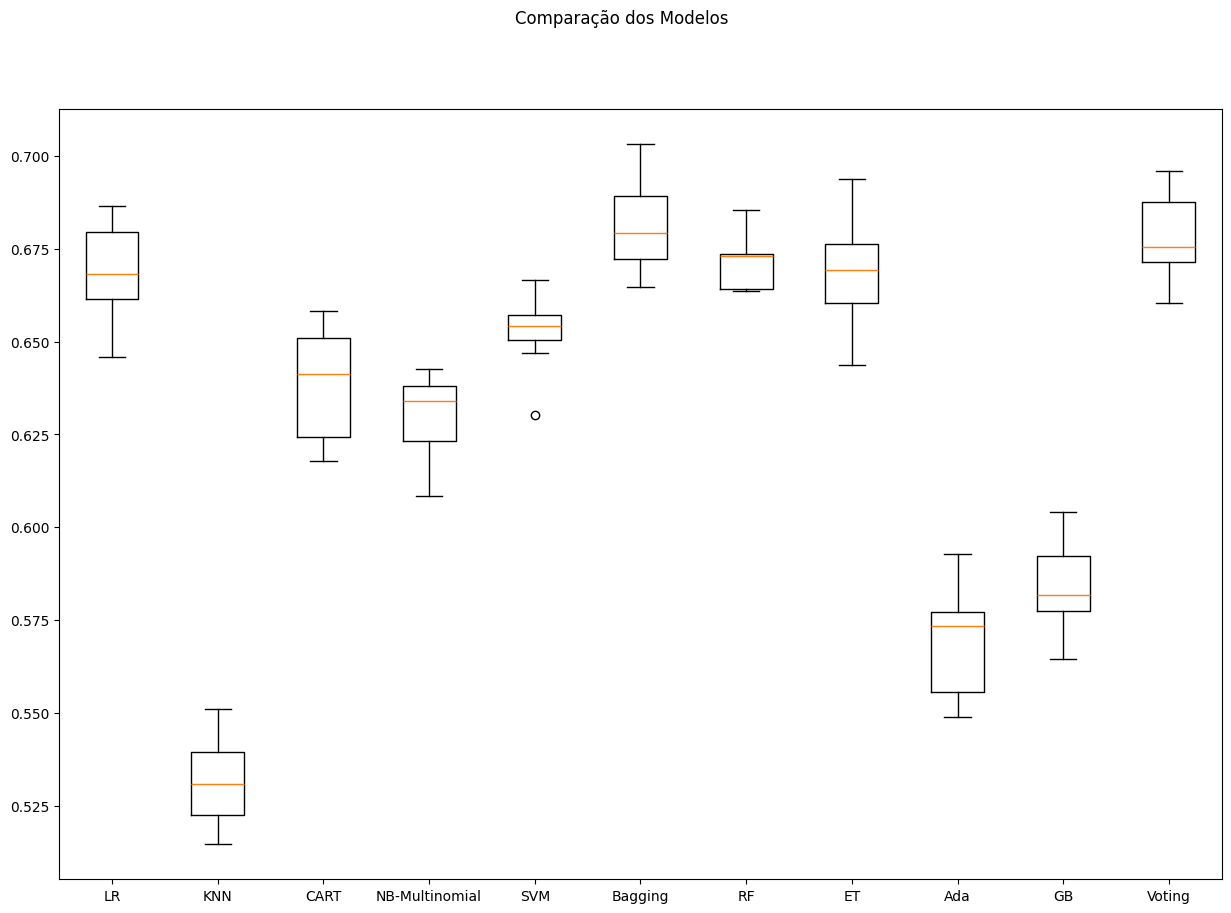

In [55]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB-Multinomial', MultinomialNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train_vec, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Otimização dos hiperparâmetros

In [56]:
# Semente global
np.random.seed(7)

# Estimador base
base_estimator = DecisionTreeClassifier()
num_trees = 100
max_features = 3
# Lista de modelos
models = []

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('lr', LogisticRegression(max_iter=10000)))
models.append(('bagging', BaggingClassifier(estimator=base_estimator)))
models.append(('rf', RandomForestClassifier()))
models.append(('voting', VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=10000)), ('cart', DecisionTreeClassifier()), ('svm', SVC(probability=True))])))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler(with_mean=False)) # Precisei adicionar o parametro `with_mean=False` para trabalhar com matris esparsas (CountVectorizer)
max_abs_scaler = ('MaxAbsScaler', MaxAbsScaler()) # Precisei alterar para o MaxAbsScaler para trabalhar com matris esparsas (CountVectorizer)

# Criação dos pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[max_abs_scaler, (name, model)])))

param_grids = {
    'lr': {
        'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'lr__C': [0.01, 0.1, 1, 10, 100],
        'lr__solver': ['liblinear', 'saga', 'lbfgs'],
    },
    'bagging' : {
        'bagging__n_estimators': [50, 100, 200, 300],
        'bagging__max_samples': [0.5, 0.7, 1.0],
        'bagging__max_features': [0.5, 0.7, 1.0, 2.0, 3.0],
        'bagging__bootstrap': [True, False],
        'bagging__bootstrap_features': [True, False],
        'bagging__oob_score': [True, False],
    },
    'rf': {
        'rf__n_estimators': [10, 50, 100, 200],
        'rf__max_features': ['auto', 'sqrt', 'log2'],
        'rf__max_depth': [None, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4]
    },    
    'voting': {
        'voting__voting': ['hard', 'soft'],
        'voting__weights': [None, (1, 1, 1), (1, 2, 1), (2, 1, 1)],
        'voting__flatten_transform': [True, False],
    }
}


# Parâmetros de cross-validation e scoring
#scoring = 'accuracy'
#kfold = 5

# Executa o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    param_grid = param_grids[model_type]
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1) #  n_jobs=-1 usa todos os núcleos do processador
    grid.fit(X_train_vec, y_train)
    # Imprimindo a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

# Levou 12 horas para executar

Modelo: lr-orig - Melhor: 0.671458 usando {'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Modelo: lr-padr - Melhor: 0.669063 usando {'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
Modelo: lr-norm - Melhor: 0.673438 usando {'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Modelo: bagging-orig - Melhor: 0.698437 usando {'bagging__bootstrap': False, 'bagging__bootstrap_features': False, 'bagging__max_features': 0.5, 'bagging__max_samples': 0.7, 'bagging__n_estimators': 300, 'bagging__oob_score': False}
Modelo: bagging-padr - Melhor: 0.696042 usando {'bagging__bootstrap': False, 'bagging__bootstrap_features': True, 'bagging__max_features': 0.5, 'bagging__max_samples': 1.0, 'bagging__n_estimators': 200, 'bagging__oob_score': False}
Modelo: bagging-norm - Melhor: 0.697708 usando {'bagging__bootstrap': False, 'bagging__bootstrap_features': True, 'bagging__max_features': 0.7, 'bagging__max_samples': 0.7, 'bagging__n_estimators': 300, 'bagging__oob_score': Fa

## Finalização do Modelo

In [59]:
# Resultados do pipeline (12h para executar)
#Modelo: lr-orig - Melhor: 0.671458 usando {'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
#Modelo: lr-padr - Melhor: 0.669063 usando {'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
#Modelo: lr-norm - Melhor: 0.673438 usando {'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
#Modelo: bagging-orig - Melhor: 0.698437 usando {'bagging__bootstrap': False, 'bagging__bootstrap_features': False, 'bagging__max_features': 0.5, 'bagging__max_samples': 0.7, 'bagging__n_estimators': 300, 'bagging__oob_score': False}
#Modelo: bagging-padr - Melhor: 0.696042 usando {'bagging__bootstrap': False, 'bagging__bootstrap_features': True, 'bagging__max_features': 0.5, 'bagging__max_samples': 1.0, 'bagging__n_estimators': 200, 'bagging__oob_score': False}
#Modelo: bagging-norm - Melhor: 0.697708 usando {'bagging__bootstrap': False, 'bagging__bootstrap_features': True, 'bagging__max_features': 0.7, 'bagging__max_samples': 0.7, 'bagging__n_estimators': 300, 'bagging__oob_score': False}
#Modelo: rf-orig - Melhor: 0.695104 usando {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
#Modelo: rf-padr - Melhor: 0.696354 usando {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
#Modelo: rf-norm - Melhor: 0.694688 usando {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
#Modelo: voting-orig - Melhor: 0.685729 usando {'voting__flatten_transform': False, 'voting__voting': 'soft', 'voting__weights': (2, 1, 1)}
#Modelo: voting-padr - Melhor: 0.661146 usando {'voting__flatten_transform': False, 'voting__voting': 'soft', 'voting__weights': (1, 1, 1)}
#Modelo: voting-norm - Melhor: 0.689063 usando {'voting__flatten_transform': False, 'voting__voting': 'soft', 'voting__weights': (2, 1, 1)}

base_estimator = DecisionTreeClassifier()

# Preparação do modelo
scaler = MaxAbsScaler().fit(X_train_vec) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train_vec) # aplicação da normalização no conjunto de treino
model = BaggingClassifier(estimator=base_estimator, n_estimators=300, max_samples=0.7, max_features=0.7, bootstrap=False, bootstrap_features=True, oob_score=False) # modelo com os melhores parâmetros
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test_vec) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.7179166666666666


## Simulando a aplicação do modelo em dados não vistos

In [62]:
# Novos dados - não sabemos a classe!
data = { 
    'content':  [
        'Excelente app! A entrega foi super rápida, e a comida chegou quentinha. Adorei a variedade de restaurantes disponíveis. Super recomendo para quem gosta de praticidade!', # 2 (Positivo)
        'O aplicativo é super intuitivo e fácil de usar. Encontrei meus drinks favoritos em minutos, e o pagamento foi muito simples. Perfeito para uma noite em casa!', # 2 (Positivo)
        'O melhor app de delivery que já usei! Além das opções saudáveis, a entrega é sempre no horário e com um ótimo atendimento. Nota 10!', # 2 (Positivo)
        'O app tem boas opções, mas os preços são um pouco altos comparados a outros serviços. A entrega foi dentro do tempo estimado, mas nada extraordinário.', # 1 (Neutro)
        'A experiência foi mediana. O app funciona bem, mas já tive problemas com entregas atrasadas. Seria ótimo se houvesse mais promoções e descontos.', # 1 (Neutro)
        'A seleção de restaurantes é boa, mas o app pode ser confuso às vezes. Precisei reiniciar algumas vezes para conseguir finalizar o pedido.', # 1 (Neutro)
        'A experiência foi frustrante. O aplicativo travou várias vezes, e meu pedido chegou errado. Além disso, o suporte ao cliente demorou muito para responder.', # 0 (Negativo)
        'Esperava mais do serviço. A comida chegou fria e com apresentação ruim. O app tem um layout bonito, mas isso não compensa a má qualidade da entrega.', # 0 (Negativo)
        'Péssimo! A entrega demorou quase duas horas e, quando finalmente chegou, a comida estava completamente gelada. Não recomendo.', # 0 (Negativo)
        'Fiquei muito decepcionado. A interface do app é confusa e difícil de navegar. Além disso, tive problemas ao tentar finalizar o pagamento. Não usarei novamente.' # 0 (Negativo)
    ]
}

entrada = pd.DataFrame(data, columns=['content'])

X_entrada = vectorizer.transform(entrada['content'].tolist())

# Predição de classes dos dados de entrada
saidas = model.predict(X_entrada)
print(saidas)

[2 2 2 0 2 0 0 0 0 0]


## Salvando os arquivos

In [63]:
# Salvando o modelo
model_filename = 'bagging_sentiment_classifier.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'maxabs_scaler_sentiment.pkl'
with open("../scalers/"+scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)  

# Salvando o pipeline
pipeline_filename = 'bagging_sentiment_pipeline.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)  

# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=dataset.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-1]])
X_test_df.to_csv("../data/X_test_dataset_sentiment.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_sentiment.csv", index=False)        

## Models - Transformers da Huggin Face

### Utilizando modelos preparados para o processamento de linguagem natural e pré-treinados na língua portuguesa.

### BERT é um modelo de linguagem natural que entende o contexto das palavras em uma frase de maneira bidirecional, tornando-o altamente eficaz para tarefas como análise de sentimentos. Ele é capaz de identificar nuances e sentimentos nos textos ao considerar as palavras ao redor de cada termo.

### DistilBERT é uma versão compacta do BERT, que mantém sua eficácia, mas com menor tamanho e maior eficiência. Ele é ideal para análise de sentimentos em situações onde os recursos computacionais são limitados, proporcionando rapidez sem comprometer significativamente a precisão.

### Mostra informações da GPU

### Faz uso da GPU para agilizar o processo de treinamento e teste

In [4]:
# Mostra informações sobre a GPU
!nvidia-smi

Sun Sep  1 14:28:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.40.06              Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:0A:00.0  On |                  N/A |
|  0%   30C    P8             19W /  370W |    1849MiB /  10240MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Encontra o tamanho máximo da sequência de tokens em cada review

In [12]:
# Carrega o tokenizer
tokenizer = AutoTokenizer.from_pretrained('adalbertojunior/distilbert-portuguese-cased', do_lower_case=False)

# Define o tamanho da sequência
token_lens = []

# Calcula o tamanho de cada sequência
for txt in dataset['content'].fillna(''):
    tokens = tokenizer(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens['input_ids']))

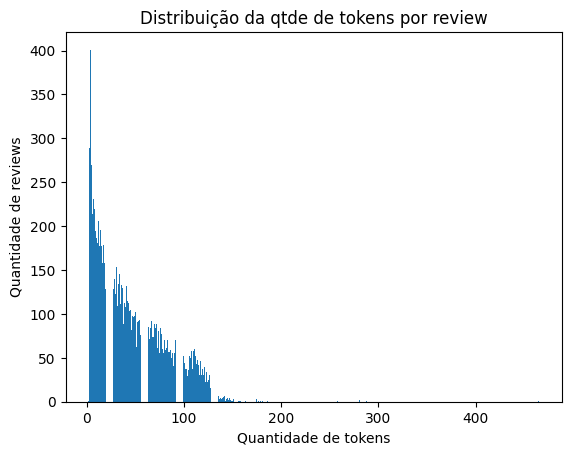

In [13]:
# Plota a distribuição do tamanho das sequencias
#plt.hist(token_lens, bins=30)

plt.bar(np.unique(token_lens, return_counts=True)[0], np.unique(token_lens, return_counts=True)[1])
plt.xlabel('Quantidade de tokens')
plt.ylabel('Quantidade de reviews')
plt.title('Distribuição da qtde de tokens por review')
plt.show()

In [14]:
# Define o tamanho máximo da sequência de tokens baseado na distribuição
MAX_LEN = 180

# Modelagem
## Modelos pré-treinados na lingua portuguesa: 

* distilbert-base-multilingual-cased
* adalbertojunior/distilbert-portuguese-cased
* neuralmindbert-base-portuguese-cased

In [15]:
# Verifica se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_EPOCH = 10

# Função para calcular métricas
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy}

# Função para treinar e avaliar o modelo
def train_and_evaluate(model_name):
    # Carrega o tokenizer e o modelo
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(y_train)), ignore_mismatched_sizes=True)
    model.to(device)

    # Tokeniza os dados de treino e teste

    tokenized_train = tokenizer(
        X_train.tolist(),  # passa a lista de textos diretamente
        max_length=MAX_LEN,
        add_special_tokens=True,
        truncation=True,
        #padding=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    tokenized_test = tokenizer(
        X_test.tolist(),  # passa a lista de textos diretamente
        max_length=MAX_LEN,
        add_special_tokens=True,
        truncation=True,
        #padding=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Define argumentos de treinamento
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=NUM_EPOCH,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch"
    )

    # Define o Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=Dataset.from_dict({"input_ids": tokenized_train["input_ids"],
                                         "attention_mask": tokenized_train["attention_mask"],
                                         "labels": y_train}),
        eval_dataset=Dataset.from_dict({"input_ids": tokenized_test["input_ids"],
                                        "attention_mask": tokenized_test["attention_mask"],
                                        "labels": y_test}),
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Treina o modelo
    trainer.train()

    # Avalia o modelo
    eval_results = trainer.evaluate()
    return  eval_results["eval_accuracy"], model, tokenizer

# Lista de modelos a serem testados
model_names = [
#    'neuralmind/bert-base-portuguese-cased',
    'distilbert/distilbert-base-multilingual-cased',
    'adalbertojunior/distilbert-portuguese-cased'
]

# Exibe a acuracia de cada modelo
results = {}
best_model = None
best_tokenizer = None
best_accuracy = 0
for model_name in model_names:
    accuracy, model, tokenizer = train_and_evaluate(model_name)
    results[model_name] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_tokenizer = tokenizer    
    print(f"Model: {model_name}, Accuracy: {accuracy}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.774300,0.805599,0.629583
2,0.659300,0.775683,0.657917
3,0.479700,0.818859,0.706667
4,0.522500,0.959174,0.698333
5,0.205400,1.313278,0.713750
6,0.325300,1.471990,0.720833
7,0.200200,1.598797,0.735000
8,0.249400,1.802092,0.728750
9,0.031300,1.910221,0.722917
10,0.193700,1.958911,0.726667


Model: distilbert/distilbert-base-multilingual-cased, Accuracy: 0.7266666666666667


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at adalbertojunior/distilbert-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.711600,0.755233,0.674167
2,0.574700,0.714603,0.704167
3,0.244300,0.915604,0.730833
4,0.385000,1.082210,0.739167
5,0.178200,1.554598,0.740417
6,0.182600,1.770430,0.751667
7,0.004600,1.996852,0.746667
8,0.049600,2.111398,0.742083
9,0.007900,2.156036,0.746250
10,0.152600,2.178444,0.750000


Model: adalbertojunior/distilbert-portuguese-cased, Accuracy: 0.75


## Melhor modelo

In [16]:
# Melhor modelo
print(f"Best Model: {best_model.config._name_or_path}, Accuracy: {best_accuracy}")

Best Model: adalbertojunior/distilbert-portuguese-cased, Accuracy: 0.75


## Simulando a aplicação do modelo em dados não vistos

In [20]:
# Novos dados - não sabemos a classe!
data = { 
    'content':  [
        'Excelente app! A entrega foi super rápida, e a comida chegou quentinha. Adorei a variedade de restaurantes disponíveis. Super recomendo para quem gosta de praticidade!', # 2 (Positivo)
        'O aplicativo é super intuitivo e fácil de usar. Encontrei meus drinks favoritos em minutos, e o pagamento foi muito simples. Perfeito para uma noite em casa!', # 2 (Positivo)
        'O melhor app de delivery que já usei! Além das opções saudáveis, a entrega é sempre no horário e com um ótimo atendimento. Nota 10!', # 2 (Positivo)
        'O app tem boas opções, mas os preços são um pouco altos comparados a outros serviços. A entrega foi dentro do tempo estimado, mas nada extraordinário.', # 1 (Neutro)
        'A experiência foi mediana. O app funciona bem, mas já tive problemas com entregas atrasadas. Seria ótimo se houvesse mais promoções e descontos.', # 1 (Neutro)
        'A seleção de restaurantes é boa, mas o app pode ser confuso às vezes. Precisei reiniciar algumas vezes para conseguir finalizar o pedido.', # 1 (Neutro)
        'A experiência foi frustrante. O aplicativo travou várias vezes, e meu pedido chegou errado. Além disso, o suporte ao cliente demorou muito para responder.', # 0 (Negativo)
        'Esperava mais do serviço. A comida chegou fria e com apresentação ruim. O app tem um layout bonito, mas isso não compensa a má qualidade da entrega.', # 0 (Negativo)
        'Péssimo! A entrega demorou quase duas horas e, quando finalmente chegou, a comida estava completamente gelada. Não recomendo.', # 0 (Negativo)
        'Fiquei muito decepcionado. A interface do app é confusa e difícil de navegar. Além disso, tive problemas ao tentar finalizar o pagamento. Não usarei novamente.' # 0 (Negativo)
    ]
}



entrada = pd.DataFrame(data, columns=['content'])

def predict(texts):
    inputs = best_tokenizer(texts, max_length=40, add_special_tokens=True, truncation=True, padding='max_length', return_attention_mask=True, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}
    outputs = best_model(**inputs)
    predictions = np.argmax(outputs.logits.detach().cpu().numpy(), axis=-1)
    return predictions

predictions = predict(data['content'])
print(f"Predictions: {predictions}")
# [2, 2, 2, 1, 1, 1, 0, 0, 0, 0] 


Predictions: [2 2 2 1 1 1 1 0 0 0]


### Salvando os arquivos

In [21]:
# Caminhos onde os arquivos serão salvos
model_path = "../models/tf_sentiment_classifier/"

# Mover o modelo para a CPU antes de salvar
best_model.cpu()

# Salva o melhor modelo e tokenizer
best_model.save_pretrained(model_path)
best_tokenizer.save_pretrained(model_path)

('../models/tf_sentiment_classifier/tokenizer_config.json',
 '../models/tf_sentiment_classifier/special_tokens_map.json',
 '../models/tf_sentiment_classifier/vocab.txt',
 '../models/tf_sentiment_classifier/added_tokens.json',
 '../models/tf_sentiment_classifier/tokenizer.json')

In [11]:
# Caminhos onde os arquivos serão salvos
#model_path = "../models/tf_sentiment_classifier/"

# Novos dados - não sabemos a classe!
#data = { 
#    'content':  [
#        'Muito bom!', # 0 (Negativo)
#        'Droga.', # 0 (Negativo)
#        'Preciso ir trabalhar' # 0 (Negativo)
#    ]
#}

#def predict(texts):
#    inputs = tokenizer(texts, max_length=40, add_special_tokens=True, truncation=True, padding='max_length', return_attention_mask=True, return_tensors='pt')
#    inputs = {key: value.to(device) for key, value in inputs.items()}
#    outputs = model(**inputs)
#    predictions = np.argmax(outputs.logits.detach().cpu().numpy(), axis=-1)
#    return predictions

# Carrega o modelo e tokenizer do disco salvos para inferência
#model = AutoModelForSequenceClassification.from_pretrained(model_path)
#tokenizer = AutoTokenizer.from_pretrained(model_path)

#device = 'cpu'

#predictions = predict(data['content'])
#print(f"Predictions: {predictions}")

Predictions: [2 0 1]
